# Machine Learning
-----


## Table of Contents
- [Introduction](#introduction)
- [Setup](#setup)
- [The Machine Learning Process](#the-machine-learning-process)
- [Problem Formulation](#model-formulation)
- [Data Exploration and Preparation](#data-exploration-and-preparation)
- [Creating Labels](#creating-labels)
- [Feature Generation](#feature-generation)
- [Modelling Preparation](#modelling-preparation)
- [Model Fitting](#model-fitting)
- [Model Evaluation](#model-evaluation)
- [Machine Learning Pipeline](#machine-learning-pipeline)
- [Deployment](#deployment)
- [Exercises](#exercises)
- [Resources](#resources)

# Introduction
In this tutorial, we'll discuss how to formulate a research question in the machine learning framework; how to transform raw data into something that can be fed into a model; how to build, evaluate, compare, and select models; and how to reasonably and accurately interpret model results. You'll also get hands-on experience using the `scikit-learn` package in Python to model the data you're familiar with from previous tutorials. 


This tutorial is based on chapter 6 of [Big Data and Social Science](https://github.com/BigDataSocialScience/).

## Setup
---
*[Back to Table of Contents](#table-of-contents)*

Before we begin, run the code cell below to initialize the libraries we'll be using in this assignment. We're already familiar with `numpy`, `pandas`, and `psycopg2` from previous tutorials. Here we'll also be using [`scikit-learn`](http://scikit-learn.org) to fit modeling.

In [7]:
%pylab inline
import pandas as pd
pd.set_option('display.max_columns', 99)
import psycopg2
import sklearn
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, 
AdaBoostClassifier)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sqlalchemy import create_engine
sns.set_style("white")

Populating the interactive namespace from numpy and matplotlib


### Connect to the database

In [ ]:
db_name = 'food'
hostname = 
conn = psycopg2.connect(database=db_name, host = hostname) #database connection

The database connection allows us to make queries to a database from Python. 

In [ ]:
df_tables = pd.read_sql("""SELECT table_schema, table_name
                          FROM information_schema.tables
                          order by table_schema, table_name;""", conn)

In [ ]:
df_tables.head()

In [26]:
raw_inspections = pd.read_csv('food_inspections.csv')

/Users/maren_eckhoff/anaconda3/envs/dssg/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
def create_int_inspections(raw_inspections: pd.DataFrame):

    int_inspections = raw_inspections.drop(columns = ['Location', # location is contained in longitude and latitude
                                                     'State']) # State is constant

    int_inspections.rename(columns = {'Inspection ID': 'inspection_id', 
                         'DBA Name': 'dba_name', 
                         'AKA Name': 'nickname', 
                         'License #': 'license_number', 
                         'Facility Type': 'facility_type',
                         'Risk': 'risk_category', 
                         'Address': 'address', 
                         'City': 'city', 
                         'Zip': 'zip', 
                         'Inspection Date': 'inspection_date',
                         'Inspection Type': 'inspection_type', 
                         'Results': 'inspection_result', 
                         'Violations': 'violations', 
                         'Latitude': 'latitude', 
                         'Longitude': 'longitude',
                         'Historical Wards 2003-2015': 'historical_wards', 
                         'Zip Codes': 'zip_codes',
                         'Community Areas': 'community_areas', 
                         'Census Tracts': 'census_tracts', 
                         'Wards': 'wards'},
             inplace = True)
    
    # fix date format
    int_inspections['inspection_date'] = pd.to_datetime(int_inspections.inspection_date)
    
    return int_inspections

In [65]:
int_inspections = create_int_inspections(raw_inspections)
int_inspections.head()

,inspection_id,dba_name,nickname,license_number,facility_type,risk_category,address,city,zip,inspection_date,inspection_type,inspection_result,violations,latitude,longitude,historical_wards,zip_codes,community_areas,census_tracts,wards
0,2293491,HAPPY CAMPER,HAPPY CAMPER,2652739.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,NaN,41.944940,-87.654864,38.0,4449.0,57.0,710.0,25.0
1,2293490,HAPPY CAMPER,HAPPY CAMPER,2652735.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,NaN,41.944940,-87.654864,NaN,NaN,NaN,NaN,NaN
2,2293539,NY KIDS CLUB,NY KIDS CLUB,2664634.0,Daycare (Under 2 Years),Risk 1 (High),2727 N LINCOLN AVE,CHICAGO,60614.0,2019-06-13,License,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.931434,-87.656924,16.0,21190.0,68.0,795.0,34.0
3,2293475,HAPPY CAMPER,HAPPY CAMPER,2652736.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.944940,-87.654864,38.0,4449.0,57.0,710.0,25.0
4,2293520,SUNNYSIDE CENTER,SUNNYSIDE CENTER,2215926.0,Daycare (Under 2 Years),Risk 1 (High),4500 N WINCHESTER AVE,CHICAGO,60640.0,2019-06-13,License,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.963339,-87.677689,13.0,22616.0,6.0,225.0,18.0


In [44]:
# basic descriptives
int_inspections.risk_category.value_counts()

Risk 1 (High)      120734
Risk 2 (Medium)     32504
Risk 3 (Low)        14256
All                    31
Name: risk_category, dtype: int64

In [25]:
# basic descriptives
int_inspections.inspection_result.value_counts()

Pass                    90723
Fail                    31232
Pass w/ Conditions      22486
Out of Business         15528
No Entry                 5863
Not Ready                1684
Business Not Located       57
Name: inspection_result, dtype: int64

In [ ]:
%matplotlib inline
int_inspections.inspection_date.hist()

In [76]:
def create_prm_inspections(int_inspections: pd.DataFrame):
    
    prm_inspections = int_inspections[['inspection_id', 
                                       'dba_name', 
                                       'nickname', 
                                       'license_number',
                                       'facility_type', 
                                       'risk_category', 
                                       'address', 
                                       'city', 
                                       'zip',
                                       'inspection_date', 
                                       'inspection_type', 
                                       'inspection_result', 
                                       'violations',
                                       'latitude', 
                                       'longitude', 
                                       'zip_codes',
                                       'community_areas', 
                                       'census_tracts']]
    prm_inspections = prm_inspections.loc[prm_inspections.inspection_date.notnull(),:]

    return prm_inspections    

In [77]:
prm_inspections = create_prm_inspections(int_inspections)
prm_inspections.head()

,inspection_id,dba_name,nickname,license_number,facility_type,risk_category,address,city,zip,inspection_date,inspection_type,inspection_result,violations,latitude,longitude,zip_codes,community_areas,census_tracts
0,2293491,HAPPY CAMPER,HAPPY CAMPER,2652739.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,NaN,41.944940,-87.654864,4449.0,57.0,710.0
1,2293490,HAPPY CAMPER,HAPPY CAMPER,2652735.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,NaN,41.944940,-87.654864,NaN,NaN,NaN
2,2293539,NY KIDS CLUB,NY KIDS CLUB,2664634.0,Daycare (Under 2 Years),Risk 1 (High),2727 N LINCOLN AVE,CHICAGO,60614.0,2019-06-13,License,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.931434,-87.656924,21190.0,68.0,795.0
3,2293475,HAPPY CAMPER,HAPPY CAMPER,2652736.0,Restaurant,Risk 1 (High),3458-3460 N CLARK ST,CHICAGO,60657.0,2019-06-13,License,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.944940,-87.654864,4449.0,57.0,710.0
4,2293520,SUNNYSIDE CENTER,SUNNYSIDE CENTER,2215926.0,Daycare (Under 2 Years),Risk 1 (High),4500 N WINCHESTER AVE,CHICAGO,60640.0,2019-06-13,License,Pass,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...",41.963339,-87.677689,22616.0,6.0,225.0


The table `information_schema.tables` contains information about all tables in the database. This comes in handy when you forget a tablename. 

# The Machine Learning Process
*[Go back to Table of Contents](#table-of-contents)*

- [**Understand the problem and goal.**](#problem-formulation) *This sounds obvious but is often nontrivial.* Problems typically start as vague 
descriptions of a goal - improving health outcomes, increasing graduation rates, understanding the effect of a 
variable *X* on an outcome *Y*, etc. It is really important to work with people who understand the domain being
studied to dig deeper and define the problem more concretely. What is the analytical formulation of the metric 
that you are trying to optimize?
- [**Formulate it as a machine learning problem.**](#problem-formulation) Is it a classification problem or a regression problem? Is the 
goal to build a model that generates a ranked list prioritized by risk, or is it to detect anomalies as new data 
come in? Knowing what kinds of tasks machine learning can solve will allow you to map the problem you are working on
to one or more machine learning settings and give you access to a suite of methods.
- **Data exploration and preparation.** Next, you need to carefully explore the data you have. What additional data
do you need or have access to? What variable will you use to match records for integrating different data sources?
What variables exist in the data set? Are they continuous or categorical? What about missing values? Can you use the 
variables in their original form, or do you need to alter them in some way?
- [**Feature engineering.**](#feature-generation) In machine learning language, what you might know as independent variables or predictors 
or factors or covariates are called "features." Creating good features is probably the most important step in the 
machine learning process. This involves doing transformations, creating interaction terms, or aggregating over data
points or over time and space.
- **Method selection.** Having formulated the problem and created your features, you now have a suite of methods to
choose from. It would be great if there were a single method that always worked best for a specific type of problem. Typically, in machine learning, you take a variety of methods and try them, empirically validating which one is the best approach to your problem.
- [**Evaluation.**](#evaluation) As you build a large number of possible models, you need a way choose the best among them. We'll cover methodology to validate models on historical data and discuss a variety of evaluation metrics. The next step is to validate using a field trial or experiment.
- [**Deployment.**](#deployment) Once you have selected the best model and validated it using historical data as well as a field
trial, you are ready to put the model into practice. You still have to keep in mind that new data will be coming in,
and the model might change over time.


# Problem Formulation
*[Go back to Table of Contents](#table-of-contents)*

When formulating a business problem as a machine learning problem, we need to ask ourselves
* What is the goal of the business
* What data is available
* What conclusions can be drawn or what actions can be take based on the approach that we propose
* Is there risk that our approach introduces biases?


## Three Main Types of ML Tasks
- **Explanation**: What properties drive the outcome and by how much? Sometimes the goal of explanatory models goes beyond the desire to understand, and there is an opportunity to take action based on the findings. In this case, the task becomes interventional. A typical example is: "What behaviour leads to a high risk of cancer?"
- **Prediction**: What will be the outcome on a new data sample? A typical example is: "How many units will I sell tomorrow?"
- **Optimisation**: How should the parameters be set to achieve an optimal outcome. In contrast to explanatory and predictive problems, in optimisation we assume that the relationships between inputs and outputs are known and the task is to determine the optimal inputs. A typical example is: "What is the best setting for the machine?"
  
## Our Machine Learning Problem
>Of all prisoners released we would like to predict who is likely to re-enter jail within *5* years of the day we make our prediction. For instance, say it is Dec 31, 2004 and we want to identify which 
>prisoners are likely to re-enter jail between now and 2015. We can run our predictive model and identify who
>is most likely at risk of recidivism. The is an example of a *binary prediction classification* problem. 

- **Unit of analysis**: Most problems can be considered at different levels of aggregation. For example, one could predict the recidivism risk for each prisoner or for each day and prisoner. The unit of analysis is the chosen level of aggregation.

- **Target variable**: The term target variable refers to the quantity or outcome of interest. An alternative term is "label".

In the example above, note that the outcome window of 5 years is completely arbitrary. You could use a window of 5, 3, 1 years or 1 day. 
The outcome window will depend on 
- how often you receive new data -- there is no sense in making the same predictions on the same data
- how accurate your predictions are for a given time period
- and on what time-scale you can use the predictions

## Supervised vs Unsupervised

Machine learning models can be categorised into supervised und unsupervised learning problems. 
- **Learning**: In the context of machine learning, the term learning refers to the process of optimising the parameters of the model for the given data set. "Learning a model" is synomous to fitting/estimating/training/building a model. All these terms are used interchangeably in the machine learning literature.


- **Supervised learning** refers to problems where there is a target or outcome variable of interest and the true value of this label is known for a significant part of the data. Supervised learning methods can therefore learn from the labelled data.
- **Unsupervised learning** refers to problems where the target variable is not known for any sample in the data set. A typicl example is the search for "natural" patterns or groupings in the data that 
we do not know about a priori. Clustering is the most common example of unsupervised learning, another example is 
principal components analysis (PCA).

## Classification vs Regression
Another way of categorising machine learning problems is based on the nature of the target variable.

- **Classification**: In classification problems, the target variable can only take a small number of values. The most common type of classification problem is binary classification where the target can only be true or false. An example is the problem above where the prisoner could re-offend or not.

- **Regression**: In regression problems, the target variable is continuous. Examples are the price of an asset, or the time until an event.

Task: What type of problem are you solving in your summer project?

In [ ]:
# test whether inspection id is a unique unit of analysis
len(prm_inspections.inspection_id.unique())/len(prm_inspections.inspection_id)

# Data Exploration and Preparation

We have covered data exploration in an earlier module. 
In order to predict recidivism, we will be using data from the `ildoc_admit` and `ildoc_exit` tables.

The next step is to engineer our dataset into **features** and **labels**.
For ease of reference, in subsequent examples, names of variables that pertain to predictors will start with "`X_`", and names of variables that pertain to outcome variables will start with "`y_`".

## Creating Labels

Labels/target variables, or *Y* variables, that we are trying to predict.

We can write SQL code in `psql`, `dbeaver`, `pgAdmin`, or programmaticaly generate the SQL and pass to the DB using `psycopg2` to create the labels. Here is the SQL code for developing labels: 


In [143]:
prm_inspections.inspection_result.value_counts()

Pass                    90723
Fail                    31232
Pass w/ Conditions      22486
Out of Business         15528
No Entry                 5863
Not Ready                1684
Business Not Located       57
Name: inspection_result, dtype: int64

In [144]:
def create_target_variable(prm_inspections: pd.DataFrame):
    
    feat_target_variable = prm_inspections[['inspection_id', 'inspection_result']].copy()
    feat_target_variable['pass_flag'] = feat_target_variable.inspection_result == 'Pass'
    
    return feat_target_variable[['inspection_id', 'pass_flag']]

In [145]:
feat_target_variable = create_target_variable(prm_inspections=prm_inspections)

In [147]:
feat_target_variable.pass_flag.value_counts()

True     90723
False    76850
Name: pass_flag, dtype: int64

## Feature Generation
*[Go back to Table of Contents](#table-of-contents)*


**Features**: Features are calculated fields that capture aspects of the problem that might be useful for solving the problem. Alternative terms are "independent variables", "predictors" and "explanatory variables".

Good features make machine learning systems effective. 
The better the features the easier it is the capture the structure of the data. You generate features by a combination of domain knowledge. In general, it is better to have more complex features and a simpler model rather than vice versa. Keeping the model simple makes it faster to train and easier to understand rather then extensively searching for the "right" model and "right" set of parameters. 

Machine Learning Algorithms learn a solution to a problem from data. The set of features is the best representation of the data to learn a solution to a problem. 

**Impact vs Feasibility**: The typical steps when planning what features to build is
- Create a list of topics that may be relevant
- Write down a list of feature ideas for each topic
- Add a priority score to each feature
- Add a feasibility score to each feature
- Map data to features
- Discuss and iterate

Once we have a prioritised list of features, the feature engineering process can begin.

- **Feature engineering** is the process of transforming raw data into features that better represent the underlying problem/data/structure to the predictive models, resulting in improved model accuracy on unseen data." ( from [Discover Feature Engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/) ). 
In text, for example, this might involve deriving traits of the text like word counts, verb counts, or topics to feed into a model rather than simply giving it the raw text.

Example of feature engineering are: 

- **Transformations**, such a log, square, and square root.
- **Dummy (binary) variables**, also known as *indicator variables*, often done by taking categorical variables
(such as city) which do not have a numerical value, and adding them to models as a binary value.
- **Discretization**. Several methods require features to be discrete instead of continuous. This is often done 
by binning, which you can do by equal width. 
- **Aggregation.** Aggregate features often constitute the majority of features for a given problem. These use 
different aggregation functions (*count, min, max, average, standard deviation, etc.*) which summarize several
values into one feature, aggregating over varying windows of time and space. For example, given urban data, 
we would want to calculate the *number* (and *min, max, mean, variance*, etc.) of crimes within an *m*-mile radius
of an address in the past *t* months for varying values of *m* and *t*, and then use all of them as features.



In [60]:
def create_date_features(prm_inspections: pd.DataFrame):
    
    feat_date_features = prm_inspections[['inspection_id', 'inspection_date']].copy()
    feat_date_features['year'] = feat_date_features.inspection_date.dt.year
    feat_date_features['month'] = feat_date_features.inspection_date.dt.month
    
    return feat_date_features

In [61]:
feat_date_features = create_date_features(prm_inspections=prm_inspections)
feat_date_features.head()

,inspection_id,inspection_date,year,month
0,2293491,2019-06-13,2019,6
1,2293490,2019-06-13,2019,6
2,2293539,2019-06-13,2019,6
3,2293475,2019-06-13,2019,6
4,2293520,2019-06-13,2019,6


In [132]:
def create_chain_features(prm_inspections: pd.DataFrame):
    
    feat_chain_features = prm_inspections[['inspection_id', 'dba_name', 'nickname']].copy()
    
    # clean dba name to get chain
    feat_chain_features['chain_name'] = feat_chain_features.dba_name.str.lower()
    feat_chain_features['chain_name'] = feat_chain_features.chain_name.str.replace("'", '')
    feat_chain_features['chain_name'] = (feat_chain_features
                                         .chain_name
                                         .str.replace("mcdonalds restaurant", "mcdonalds")
                                         .str.replace("mc donalds", "mcdonalds")
                                         .str.replace("subway sandwiches", "subway")
                                         .str.replace("kentucky fried chicken", "kfc")
                                         .str.replace("dunkin donuts/baskin robbins", "dunkin donuts")
                                         .str.replace("popeyes chicken", "popeyes")
                                        .str.replace("potbelly sandwich works llc", "potbelly sandwich works"))
    feat_chain_features['chain_name'] = feat_chain_features.chain_name.str.replace(' ', '_')
    feat_chain_features.drop(columns = 'dba_name', inplace = True)

    # identify chains more frequent than 0.1% of the data
    frequent_chains = feat_chain_features.chain_name.value_counts()/len(feat_chain_features)
    frequent_chains = frequent_chains[frequent_chains>0.001]
    
    # make dummies for the frequent chains
    mask = feat_chain_features.chain_name.isin(list(frequent_chains.index))
    dummy_features = pd.get_dummies(feat_chain_features.chain_name[mask])
    
    # add dummies to feat data set
    feat_chain_features = pd.merge(left = feat_chain_features,
                                  right = dummy_features,
                                  right_index = True,
                                  left_index = True,
                                  how = 'left')
    
    # For those that are none of the frequent ones, add 0 values
    feat_chain_features = feat_chain_features.fillna(0)
    
    return feat_chain_features

In [133]:
feat_chain_features = create_chain_features(prm_inspections)

In [134]:
feat_chain_features.head()

,inspection_id,nickname,chain_name,7-eleven,au_bon_pain,chipotle_mexican_grill,corner_bakery_cafe,dominos_pizza,dunkin_donuts,freshii,jimmy_johns,kfc,mcdonalds,popeyes,potbelly_sandwich_works,subway,whole_foods_market
0,2293491,HAPPY CAMPER,happy_camper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2293490,HAPPY CAMPER,happy_camper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2293539,NY KIDS CLUB,ny_kids_club,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2293475,HAPPY CAMPER,happy_camper,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2293520,SUNNYSIDE CENTER,sunnyside_center,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
def create_master_table(feat_chain_features: pd.DataFrame,
                       feat_date_features: pd.DataFrame,
                       feat_target_variable: pd.DataFrame):
    
    mst_master_table = pd.merge(left = feat_date_features,
                               right = feat_chain_features,
                               on = 'inspection_id',
                               how = 'inner')

    mst_master_table = pd.merge(left = mst_master_table,
                           right = feat_target_variable,
                           on = 'inspection_id',
                           how = 'inner')
    
    return mst_master_table    

In [131]:
len(feat_date_features)

167573

In [148]:
mst_master_table = create_master_table(feat_chain_features=feat_chain_features,
                                       feat_date_features=feat_date_features,
                                      feat_target_variable=feat_target_variable)

In [151]:
len(mst_master_table)

167573

## Modelling Preparation
*[Go back to Table of Contents](#table-of-contents)*

Before diving into the modelling, it's important to set up in such a way that we can estimate model performance.
We're going to need a way to know whether or not it's working. Convincing others of the quality of results is often the *most challenging* part of an analysis.  Making repeatable, well-documented work with clear success metrics makes all the difference.

To convince ourselves - and others - that our modeling results will generalize, we need to hold
some data back (not using it to train the model), then apply our model to that hold-out set and "blindly" predict, comparing the model's predictions to what we actually observed. 
This is called **train-test split**, and it's the best way we have to estimate how a model will perform on *entirely* novel data. We call the data used to build the model the **training set**, and the rest the **test set**.

In general, we'd like our training set to be as large as possible, to give our model more information. However, you also want to be as confident as possible that your model will be applicable to new data, or else the model is useless. In practice, you'll have to balance these two objectives in a reasonable way.  

There are also many ways to split up your data into training and testing sets. 
Since you're trying to evaluate how your model will perform *in practice*, it's best to emulate the use case of your model as closely as possible when you decide how to evaluate it. 

One simple and commonly used method is ***k-fold* cross-validation**, which entails splitting up our dataset into *k* groups, holding out one group while training a model on the rest of the data, evaluating model performance on the held-out "fold," and repeating this process *k* times (we'll get back to this in the text-analysis tutorial). 
A good [tutorial on cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) can be found on the `scikit-learn` site.

Another method is **temporal cross-validation**, which involves building a model using all the data up until a given point in time, and then testing the model on observations that happened after that point. 
Our problem of recidivism is a problem in time where we are trying to predcit an event in the future. G
enerally, if you use the future to predict the past there will be temporal effects that will help the accuracy of your predictions. 
We cannot use the future to predict the past in real life, so it is important to use `temporal cross-validation` and create our training and test sets accordingly. 


- **Samples**: Each sample is a realisation of the unit of analysis in the data set. It can be used as one example for learning. Synonyms are "data point" or "observation"

In [149]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mst_master_table, test_size=0.2)

In [153]:
train.pass_flag.value_counts()

True     72518
False    61540
Name: pass_flag, dtype: int64

### Split into features and labels

In [154]:
x_cols = ['year', 'month', '7-eleven', 'au_bon_pain', 'chipotle_mexican_grill',
       'corner_bakery_cafe', 'dominos_pizza', 'dunkin_donuts', 'freshii',
       'jimmy_johns', 'kfc', 'mcdonalds', 'popeyes', 'potbelly_sandwich_works',
       'subway', 'whole_foods_market']
y_col = 'pass_flag'

In [155]:
X_train = train[x_cols]
y_train = train[y_col]
X_test = test[x_cols]
y_test = test[y_col]

# Model Fitting
*[Go back to Table of Contents](#table-of-contents)*

Python's [`scikit-learn`](http://scikit-learn.org/stable/) is a commonly used, well documented Python library for machine learning. 
This library can help you split your data into training and test sets, fit models and use them to predict results on new data, and evaluate your results.

There is a large number of properties to think about when choosing the model and fitting it.

- **Underfitting**: Underfitting occurs when the chosen model is too simple to capture the structure on the data well enough.
- **Overfitting**: Overfitting occurs when the model is too complex. In this case, it may become overly sensitive to the noise in the data and replicate phenomena in the training set that are not systematic. Overfitting results in poor generalization performance, i.e. poor applicability of the model to new data.

A nice image explaining the issue is available on [sklearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html)

One common method to combat overfitting is **Regularization**: Regularization is a technique to avoid overfitting by applying additional constraints to the model. 
For example, one can limit the number of features present in the final model, or penalise the size of the coefficients used in the model.


We will start with the simplest [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with an L2 penalty and see how well that does.


In [162]:
# Let's fit the model
from sklearn import linear_model
model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs')
#model = linear_model.LogisticRegression(penalty='l2', C=1e5, solver = 'lbfgs')
model.fit(X_train, y_train)
print(model)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


When we print the model results, we see different parameters we can adjust as we refine the model based on running it against test data (values such as `intercept_scaling`, `max_iters`, `penalty`, and `solver`).  Example output:

    LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

To adjust these parameters, one would alter the call that creates the `LogisticRegression()` model instance, passing it one or more of these parameters with a value other than the default.  So, to re-fit the model with `max_iter` of 1000, `intercept_scaling` of 2, and `solver` of "lbfgs" (pulled from thin air as an example), you'd create your model as follows:

    model = LogisticRegression( max_iter = 1000, intercept_scaling = 2, solver = "lbfgs" )

The basic way to choose values for, or "tune," these parameters is the same as the way you choose a model: fit the model to your training data with a variety of parameters, and see which perform the best on the test set. An obvious drawback is that you can also *overfit* to your test set; in this case, you can alter your method of cross-validation.



In [ ]:
def build_model(mst_master_table: pd.DataFrame):

    # data prep 
    train, test = train_test_split(mst_master_table, test_size=0.2)
    
    x_cols = ['year', 'month', '7-eleven', 'au_bon_pain', 'chipotle_mexican_grill',
       'corner_bakery_cafe', 'dominos_pizza', 'dunkin_donuts', 'freshii',
       'jimmy_johns', 'kfc', 'mcdonalds', 'popeyes', 'potbelly_sandwich_works',
       'subway', 'whole_foods_market']
    y_col = 'pass_flag'
    
    X_train = train[x_cols]
    y_train = train[y_col]
    X_test = test[x_cols]
    y_test = test[y_col]
    
    # modelling 
    from sklearn import linear_model
    model = linear_model.LogisticRegression(penalty='none', solver = 'lbfgs')
    #model = linear_model.LogisticRegression(penalty='l2', C=1e5, solver = 'lbfgs')
    model.fit(X_train, y_train)

    return model
    

In [ ]:
model = build_model(mst_master_table=mst_master_table)

## Model Evaluation
*[Go back to Table of Contents](#table-of-contents)*

In this phase, you take the predictors from your test set and apply your model to them, then assess the quality of the model by comparing the *predicted values* to the *actual values* for each record in your testing data set. 

- **Performance Estimation**: How well will our model do once it is deployed and applied to new data?


Machine learning models usually do not produce a prediction (0 or 1) directly. Rather, models produce a score (that can sometimes be interpreted a a probabilty) between 0 and 1, which lets you more finely rank all of the examples from *most likely* to *least likely* to have label 1 (positive). 
This score is then turned into a 0 or 1 based on a user-specified threshold. 
For example, you might label all examples that have a score greater than 0.5 (1/2) as positive (1), but there's no reason that has to be the cutoff. 

In [163]:
#  from our "predictors" usin the model.
y_score = model.predict_proba(X_test)[:,1]

In [164]:
y_score

array([0.54234406, 0.53351144, 0.53349572, ..., 0.52447892, 0.53052259,
       0.53046306])

Let's take a look at the distribution of scores and see if it makes sense to us. 

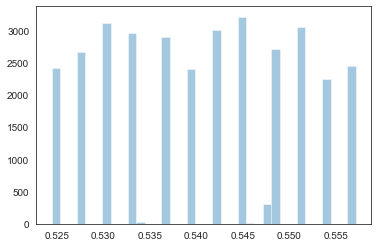

In [165]:
sns.distplot(y_score, kde=False, rug=False)

In [167]:
test['y_predicted'] = y_score

/Users/maren_eckhoff/anaconda3/envs/dssg/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
test[['pass_flag', 'y_predicted']].head()

,pass_flag,y_predicted
36147,False,0.542344
12848,False,0.533511
52288,False,0.533496
120495,False,0.536320
15965,True,0.542447


Tools like `sklearn` often have a default threshold of 0.5, but a good threshold is selected based on the data, model and the specific problem you are solving. As a trial run, let's set a threshold of 0.5. 

In [178]:
calc_threshold = lambda x,y: 0 if x < y else 1 
predicted = np.array([calc_threshold(score,0.54) for score in y_score] )
expected = y_test

## Confusion Matrix

Once we have tuned our scores to 0 or 1 for classification, we create a *confusion matrix*, which  has four cells: true negatives, true positives, false negatives, and false positives. Each data point belongs in one of these cells, because it has both a ground truth and a predicted label. If an example was predicted to be negative and is negative, it's a true negative. If an example was predicted to be positive and is positive, it's a true positive. If an example was predicted to be negative and is positive, it's a false negative. If an example was predicted to be positive and is negative, it's a false negative.

In [179]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(expected,predicted)

In [180]:
conf_matrix

array([[7841, 7469],
       [8678, 9527]])

The count of true negatives is `conf_matrix[0,0]`, false negatives `conf_matrix[1,0]`, true positives `conf_matrix[1,1]`, and false_positives `conf_matrix[0,1]`.

Accuracy is the ratio of the correct predictions (both positive and negative) to all predictions. 
$$ Accuracy = \frac{TP+TN}{TP+TN+FP+FN} $$

In [181]:
# generate an accuracy score by comparing expected to predicted.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(expected, predicted)
print( "Accuracy = " + str( accuracy ) )

Accuracy = 0.5182157243025511


Two additional metrics that are often used are **precision** and **recall**. 

Precision measures the accuracy of the classifier when it predicts an example to be positive. It is the ratio of correctly predicted positive examples to examples predicted to be positive. 

$$ Precision = \frac{TP}{TP+FN}$$

Recall measures the accuracy of the classifier to find positive examples in the data. 

$$ Recall = \frac{TP}{TP+FN} $$

By selecting different thresholds we can vary and tune the precision and recall of a given classifier. A conservative classifier (threshold 0.99) will classify a case as 1 only when it is *very sure*, leading to high precision. On the other end of the spectrum, a low threshold (e.g. 0.01) will lead to higher recall. 

In [182]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(expected, predicted)
recall = recall_score(expected, predicted)
print( "Precision = " + str( precision ) )
print( "Recall= " + str(recall))

Precision = 0.5605436573311368
Recall= 0.5233177698434496


If we care about our whole precision-recall space, we can optimize for a metric known as the **area under the curve (AUC-PR)**, which is the area under the precision-recall curve. The maximum AUC-PR is 1. 

In [183]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score)
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.541308


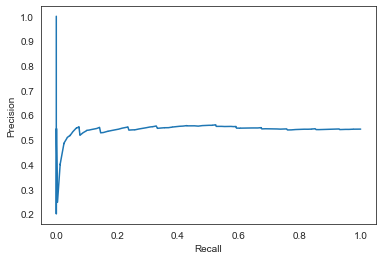

<Figure size 432x288 with 0 Axes>

In [184]:
plot_precision_recall(expected, y_score)

## Precision and Recall at k%

If we only care about a specific part of the precision-recall curve we can focus on more fine-grained metrics. 

In [185]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()
    plt.clf()

In [186]:
def precision_at_k(y_true, y_scores,k):
    
    threshold = np.sort(y_scores)[::-1][int(k*len(y_scores))]
    y_pred = np.asarray([1 if i >= threshold else 0 for i in y_scores ])
    return precision_score(y_true, y_pred)

<Figure size 432x288 with 0 Axes>

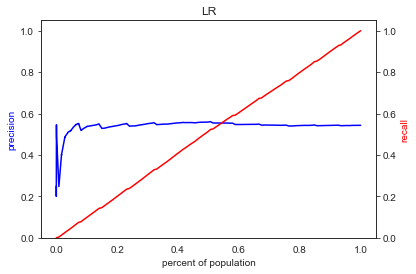

<Figure size 432x288 with 0 Axes>

In [187]:
plot_precision_recall_n(expected,y_score, 'LR')

In [188]:
p_at_5 = precision_at_k(expected,y_score, 0.05)
print('Precision at 5%: {:.2f}'.format(p_at_5))

Precision at 5%: 0.53


## Machine Learning Pipeline
*[Go back to Table of Contents](#table-of-contents)*

When working on machine learning projects, it is a good idea to structure your code as a modular **pipeline**, which contains all of the steps of your analysis, from the original data source to the results that you report, along with documentation. This has many advantages:
- **Reproducibility**. It's important that your work be reproducible. This means that someone else should be able
to see what you did, follow the exact same process, and come up with the exact same results. It also means that
someone else can follow the steps you took and see what decisions you made, whether that person is a collaborator, 
a reviewer for a journal, or the agency you are working with. 
- **Ease of model evaluation and comparison**.
- **Ability to make changes.** If you receive new data and want to go through the process again, or if there are 
updates to the data you used, you can easily substitute new data and reproduce the process without starting from scratch.

In [ ]:
# build intermediate layer
int_inspections = create_int_inspections(raw_inspections=raw_inspections)
# build primary layer
prm_inspections = create_prm_inspections(int_inspections=int_inspections)
# build feature layer
feat_target_variable = create_target_variable(prm_inspections=prm_inspections)
feat_date_features = create_date_features(prm_inspections=prm_inspections)
feat_chain_features = create_chain_features(prm_inspections=prm_inspections)
# build master table
mst_master_table = create_master_table(feat_chain_features=feat_chain_features,
                                       feat_date_features=feat_date_features,
                                      feat_target_variable=feat_target_variable)
# build model
model = build_model(mst_master_table=mst_master_table)
# evaluate model
model_eval = evaluate_model(model, master_table)

# TODO: Write the model evaluation function


# Exercise 2
*[Go back to Table of Contents](#table-of-contents)*

We have only scratched the surface of what we can do with our model. We've only tried one classifier (Logistic Regression), and there are plenty more classification algorithms in `sklearn`. Let's try them! 


In [ ]:
clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
       'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SGD':SGDClassifier(loss='log'),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB()}

In [ ]:
sel_clfs = ['RF', 'ET', 'LR', 'SGD', 'GB', 'NB']

In [ ]:
max_p_at_k = 0
for clfNM in sel_clfs:
    clf = clfs[clfNM]
    clf.fit( X_train, y_train )
    print clf
    y_score = clf.predict_proba(X_test)[:,1]
    predicted = np.array(y_score)
    expected = np.array(y_test)
    plot_precision_recall_n(expected,predicted, clfNM)
    p_at_5 = precision_at_k(expected,y_score, 0.05)
    if max_p_at_k < p_at_5:
        max_p_at_k = p_at_5
    print('Precision at 5%: {:.2f}'.format(p_at_5))

# Baseline 

It is important to check our model against a reasonable **baseline** to know how well our model is doing. Without any context, 83% accuracy can sound really great... but it's not so great when you remember that you could do almost that well by declaring everyone a non-recividist, which would be stupid (not to mention useless) model. 

A good place to start is checking against a *random* baseline, assigning every example a label (positive or negative) completely at random. 

In [ ]:
max_p_at_k

In [ ]:
random_score = [random.uniform(0,1) for i in enumerate(y_test)] 
random_predicted = np.array( [calc_threshold(score,0.5) for score in random_score] )
random_p_at_5 = precision_at_k()

Another good practice is checking against an "expert" or rule of thumb baseline.

In [ ]:
recidivism_predicted = np.array([ 1 if nadmit > 1 else 0 for nadmit in df_testing.nadmits.values ])
recidivism_p_at_5 = precision_at_k(expected,predicted,0.05)

In [ ]:
all_non_recidivist = np.array([0 for nadmit in df_testing.nadmits.values])
all_non_recidivist_p_at_5 = precision_at_k()

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, figsize=(22,12))
sns.set_context("poster", font_scale=2.25, rc={"lines.linewidth":2.25, "lines.markersize":8})
sns.barplot([],
            [],
            palette=['#6F777D','#6F777D','#6F777D','#800000'])
plt.ylim(0,1)
plt.ylabel('precision at 5%')

# Exercise 

Our model has just scratched the surface. Try the following: 
    
- Create more features
- Try more models
- Try different parameters for your model

## Resources
*[Go back to Table of Contents](#table-of-contents)*

- Hastie et al.'s [The Elements of Statistical Learning](http://statweb.stanford.edu/~tibs/ElemStatLearn/) is a classic and is available online for free.
- James et al.'s [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/), also available online, includes less mathematics and is more approachable.
- Wu et al.'s [Top 10 Algorithms in Data Mining](http://www.cs.uvm.edu/~icdm/algorithms/10Algorithms-08.pdf).